# Canopy Height estimation hackathon

This is my entry to the Canopy height hackathon in OpenGeoHub's summerschool 2025. The hackathon is available [here](https://www.kaggle.com/competitions/canopy-height-mapping-using-google-aef-embeddings/overview).

The objective of this hackathon is to predict canopy height as measured by the GEDI-sensor at **rh98** level from Google's Alpha Earth Foundations (AEF) embeddings in the Netherlands.

This approach uses a small multi-layer perceptron model implemented in pytorch to estimate canopy height.

In [1]:
import torch.cuda

from ressources import data

from ressources.model import MlpModel, train_loop, test_loop
from torch import nn
from torch.optim import SGD

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

embed_cols = [f"cv_{str(x)}_google.embedding_nl" for x in range(1, 65)]
full_data = pd.read_csv("data/train.csv")[["rh98", "lon", "lat", *embed_cols]]
full_data

,rh98,lon,lat,cv_1_google.embedding_nl,cv_2_google.embedding_nl,cv_3_google.embedding_nl,cv_4_google.embedding_nl,cv_5_google.embedding_nl,cv_6_google.embedding_nl,cv_7_google.embedding_nl,...,cv_55_google.embedding_nl,cv_56_google.embedding_nl,cv_57_google.embedding_nl,cv_58_google.embedding_nl,cv_59_google.embedding_nl,cv_60_google.embedding_nl,cv_61_google.embedding_nl,cv_62_google.embedding_nl,cv_63_google.embedding_nl,cv_64_google.embedding_nl
0,305,5.856984,51.179637,-0.119093,-0.108512,-0.172795,-0.032541,-0.048228,-0.199862,0.088827,...,0.214133,-0.041584,-0.015748,-0.015748,-0.088827,-0.135886,0.079723,-0.098424,-0.113741,-0.103406
1,354,5.150759,50.787853,-0.186082,-0.108512,-0.221453,0.048228,-0.059116,-0.310096,0.141730,...,0.192910,-0.024606,0.010396,-0.044844,-0.113741,-0.098424,0.048228,-0.135886,-0.113741,-0.055363
2,498,4.177618,51.211171,-0.236463,-0.141730,-0.153787,0.001538,-0.035433,-0.228897,0.113741,...,0.244152,-0.059116,-0.029773,-0.084214,-0.062991,-0.124567,0.032541,-0.135886,-0.079723,-0.048228
3,453,5.722639,50.938367,-0.147697,-0.119093,-0.221453,0.044844,-0.035433,-0.251965,0.141730,...,0.214133,-0.048228,0.044844,-0.015748,-0.124567,-0.124567,0.071111,-0.108512,-0.153787,-0.084214
4,302,6.957367,51.288644,-0.108512,-0.153787,-0.075356,-0.084214,0.153787,0.017778,0.172795,...,0.292872,-0.228897,-0.066990,-0.013841,-0.062991,-0.059116,-0.013841,-0.055363,-0.130165,-0.051734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39530,291,5.585460,51.078604,-0.172795,-0.172795,-0.179377,0.041584,0.013841,-0.199862,0.108512,...,0.135886,-0.103406,0.032541,-0.022207,0.012057,-0.098424,0.088827,-0.088827,-0.075356,-0.147697
39531,372,6.409002,51.299053,-0.206936,-0.186082,-0.192910,0.098424,0.000062,-0.284444,0.119093,...,0.166336,-0.084214,0.017778,-0.032541,-0.103406,-0.032541,0.051734,-0.135886,-0.113741,-0.103406
39532,316,6.083587,51.727376,-0.147697,-0.032541,-0.192910,-0.035433,0.019931,-0.199862,0.130165,...,0.160000,-0.093564,-0.015748,-0.062991,0.029773,-0.160000,0.027128,-0.088827,0.024606,-0.135886
39533,330,6.084410,51.727351,-0.141730,-0.062991,-0.214133,-0.006151,0.010396,-0.206936,0.098424,...,0.160000,-0.093564,-0.003937,-0.029773,-0.001538,-0.160000,0.032541,-0.084214,0.022207,-0.113741


## Correlation

As all embeddings provided represent vegetation, it is my suspision, that they are correlated. Using a Principal Component Analysis (PCA), we can see that this is indeed the case. We can therefore PCA-transform the 64-dimensional embedding to a 42-dimensional embedding while still keeping 99% of variability from the data.

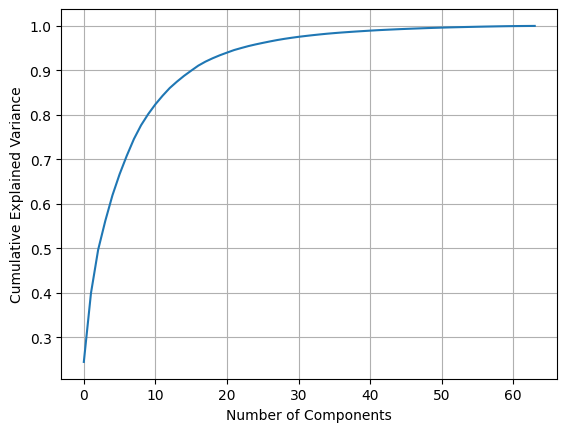

Target dimension: 42


In [2]:
pca = PCA()
X_pca = pca.fit_transform(full_data.iloc[:, 3:])

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

explained_variance = np.cumsum(pca.explained_variance_ratio_)
target_dim = np.argmax(explained_variance >= 0.99) + 1
print("Target dimension:", target_dim)

In [3]:
embedding_pca = PCA(target_dim)
training_pca_transformed = embedding_pca.fit_transform(full_data.iloc[:, 3:])
full_data_pca = pd.DataFrame(
    {
        "rh98": full_data["rh98"], "lon": full_data["lon"], "lat": full_data["lat"],
        **{f"emb_{x}": training_pca_transformed[:, x] for x in range(training_pca_transformed.shape[1])}
    }
)

## Training the model

We can now train an MLP model with 42 inputs. The architecture is one input layer, one hidden Layer with also 42 outputs, then a ReLU layer and last but not least one layer which outputs a single number, which is the predicted canopy height.

We split our training data randomly to have a training dataset which contains 80% of the data, and a validation dataset containing 20% of the data

We use an Mean Square Error loss function and a Stochastic Gradient Decent optimizer. We then train for 20 epochs with a learning rate of 1e-4 and then for 50 more epochs with a learning rate of 1e-5. Calculating the square root of the loss gives us the RMSE loss requested in the hackathon.

In [4]:
df_train, df_test = train_test_split(full_data_pca, train_size=0.8, random_state=42)

In [5]:
training_loader = data.get_training_loader(df_train, 64)
validation_loader = data.get_validation_loader(df_test, 64)

Validation data samples: 31628 in 495 batches
Training data samples: 7907 in 124 batches


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device=}")
model = MlpModel(target_dim)
model = model.to(device)
loss_fn = nn.MSELoss()

device='cuda'


In [7]:
train_losses = []
test_losses = []
def train_the_model(n_epochs: int, learning_rate: float):
    print(f"----- Training {n_epochs} epochs with LR {learning_rate} on {device}-----")
    optimizer = SGD(model.parameters(), learning_rate)
    for t in range(n_epochs):
        train_loop(device, training_loader, model, loss_fn, optimizer)
        train_loss, test_loss = test_loop(device, validation_loader, training_loader, model, loss_fn, t)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

In [8]:
train_the_model(20, 1e-4)
train_the_model(25, 1e-5)

----- Training 20 epochs with LR 0.0001 on cuda-----
Epoch 1 RMSE: 555.433236 (Training), 551.800675 (Validation)
Epoch 2 RMSE: 551.841041 (Training), 547.859955 (Validation)
Epoch 3 RMSE: 550.819615 (Training), 546.660098 (Validation)
Epoch 4 RMSE: 550.120302 (Training), 545.813914 (Validation)
Epoch 5 RMSE: 549.626790 (Training), 545.204236 (Validation)
Epoch 6 RMSE: 549.192301 (Training), 544.671584 (Validation)
Epoch 7 RMSE: 548.859951 (Training), 544.243887 (Validation)
Epoch 8 RMSE: 548.565761 (Training), 543.862652 (Validation)
Epoch 9 RMSE: 547.900755 (Training), 543.028362 (Validation)
Epoch 10 RMSE: 547.052787 (Training), 542.034121 (Validation)
Epoch 11 RMSE: 546.548811 (Training), 541.419161 (Validation)
Epoch 12 RMSE: 546.089420 (Training), 540.924805 (Validation)
Epoch 13 RMSE: 545.761666 (Training), 540.558645 (Validation)
Epoch 14 RMSE: 545.455826 (Training), 540.242100 (Validation)
Epoch 15 RMSE: 545.157555 (Training), 539.858695 (Validation)
Epoch 16 RMSE: 544.913076 

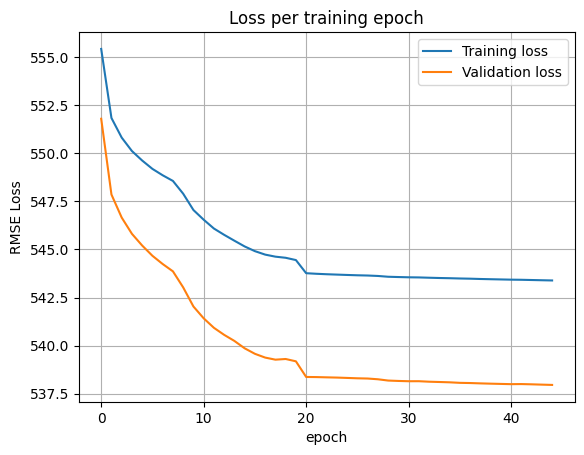

In [9]:
x = range(len(train_losses))
plt.plot(x, train_losses, label="Training loss")
plt.plot(x, test_losses, label="Validation loss")
plt.xlabel("epoch")
plt.ylabel("RMSE Loss")
plt.legend()
plt.grid(True)
plt.title("Loss per training epoch")
plt.show()

## Predictions

Now with the model fitted, let's use it to predict on the test dataset. Like the trianing dataset , we first PCA-transform it to 42 dimensions, then write it to a CSV file.

In [10]:
comp_data = pd.read_csv("data/test.csv")[["id", *embed_cols]]
comp_pca_transformed = embedding_pca.transform(comp_data.iloc[:, 1:])
comp_data_pca = pd.DataFrame(
    {
        "id": comp_data["id"],
        **{f"emb_{x}": comp_pca_transformed[:, x] for x in range(comp_pca_transformed.shape[1])}
    }
)
comp_data_pca

,id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41
0,1,0.098184,-0.050422,-0.309363,-0.186484,0.157995,-0.128830,0.253611,0.121920,0.056051,...,-0.010423,0.015298,-0.010365,-0.001333,0.018006,0.001503,-0.017694,-0.003101,-0.013154,0.003831
1,2,0.299813,0.410273,0.080700,-0.039026,-0.055786,0.002572,0.088366,-0.038919,0.124380,...,-0.013968,0.008911,-0.013830,-0.022166,0.015903,0.015457,-0.026392,-0.003179,-0.007950,-0.012545
2,3,0.289541,0.591452,0.040536,-0.141412,0.098441,-0.014979,0.001993,-0.026909,0.030016,...,-0.005357,-0.001226,-0.005258,-0.015456,-0.015293,0.015988,-0.019792,0.011545,0.006850,-0.015200
3,4,0.087172,-0.041978,0.127846,0.029140,0.385103,-0.021343,-0.154044,-0.102226,0.170550,...,-0.003817,-0.002651,0.018563,-0.022713,-0.008604,-0.008814,-0.002342,0.018267,-0.024721,0.000262
4,5,0.293596,0.400274,-0.206790,0.050914,0.068393,0.252578,-0.072320,-0.107099,0.096958,...,-0.013702,-0.000530,0.008189,0.010789,0.060730,-0.027799,0.029808,0.009438,-0.001926,-0.000227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19740,19741,0.124356,0.055292,0.160119,-0.127073,-0.070531,-0.128157,-0.040685,-0.006971,-0.096887,...,0.008724,-0.031771,0.025176,0.004283,-0.014489,-0.004691,0.009757,-0.013446,0.009738,-0.003092
19741,19742,0.437341,0.192566,-0.136774,0.070791,-0.051346,0.031851,-0.025754,0.010846,0.023378,...,0.022731,-0.020276,0.001296,-0.002200,0.016703,0.005717,0.002368,-0.006046,-0.005054,0.018677
19742,19743,0.289519,-0.215994,0.047144,0.004733,0.026973,-0.121223,0.008702,-0.037391,0.071807,...,0.009730,0.011404,0.019399,-0.006116,-0.015250,-0.002256,-0.022257,0.008617,0.005430,0.010380
19743,19744,0.099856,-0.090004,0.123928,0.028350,0.359291,-0.024482,-0.124453,-0.103750,0.167436,...,-0.004976,0.008533,0.019818,-0.019037,-0.002065,-0.008786,0.013029,0.017638,-0.022414,-0.002106


In [11]:
input_data = torch.from_numpy(comp_data_pca.iloc[:, 1:].to_numpy().astype(np.float32)).to(device)

with torch.no_grad():
    preds = model(input_data).to("cpu").numpy().flatten()

ids = range(1, preds.shape[0]+1)

result_df = pd.DataFrame(
    data={"id": ids, "rh98": preds}
)
result_df

,id,rh98
0,1,1718.561646
1,2,1912.204224
2,3,1985.498779
3,4,589.626709
4,5,1993.938232
...,...,...
19740,19741,2062.966064
19741,19742,2827.374268
19742,19743,2323.905762
19743,19744,668.109741


In [12]:
result_df.to_csv("./results.csv", index=False)